In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from einops import rearrange
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split

from uni2ts.eval_util.plot import plot_single, plot_next_multi
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
from uni2ts.model.moirai_moe import MoiraiMoEForecast, MoiraiMoEModule
from uni2ts.model.moirai2 import Moirai2Forecast, Moirai2Module

MODEL = "moirai2"  # model name: choose from {'moirai', 'moirai-moe', 'moirai2'}

# 1. Forecasting with Moirai

# 1. 使用Moirai进行预测

<img src="img/pred_def.png" alt="Drawing" style="width: 800px;"/>

Given a time series, Moirai (prediction model) use the context window as input and outputs a prediction window. So, the user need to set the **context_length** and **prediction_length** in advance. 

For time series data, the information contained within a single timestamp is not rich enough. Therefore, we refer to consecutive time points as 'patches', forming the basic units of Moirai input (similar to the concept of word token in Language Models). Moirai provides various ***patch_size*** [8, 16, 32, 64, 128].

Additionally, users need to select the **model size** ('small', 'base', 'large') of Moirai for prediction, along with the **batch_size**, which determines the number of samples that can be inferred in parallel. Since Moirai supports probablistic forecast, users should specify the **num_samples**, indicating the number of times it has to sample the forecasting distribution.

给定一个时间序列，Moirai（预测模型）使用上下文窗口作为输入并输出预测窗口。因此，用户需要预先设置**context_length**和**prediction_length**。

对于时间序列数据，单个时间戳中包含的信息不够丰富。因此，我们将连续的时间点称为'patches'，形成Moirai输入的基本单位（类似于语言模型中的词元概念）。Moirai提供各种***patch_size*** [8, 16, 32, 64, 128]。

此外，用户需要为预测选择Moirai的**模型大小**（'small', 'base', 'large'），以及**batch_size**，它确定可以并行推断的样本数量。由于Moirai支持概率预测，用户应指定**num_samples**，表示需要从预测分布中采样的次数。

total length: 240
time frequency: 0 days 01:00:00


<Axes: >

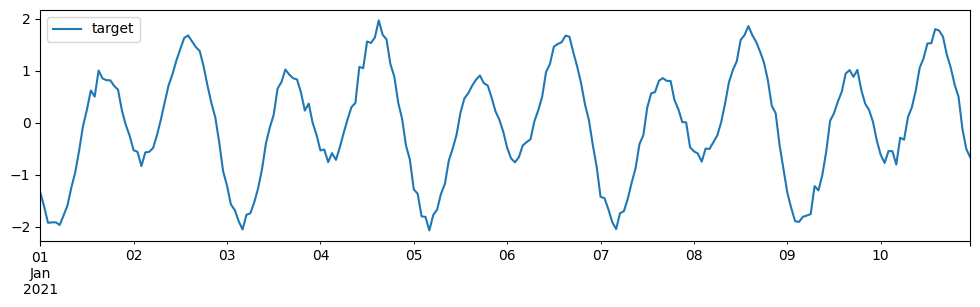

In [2]:
# Load dataframe and plot it
# 加载数据框并绘图
url = (
    "https://gist.githubusercontent.com/rsnirwan/a8b424085c9f44ef2598da74ce43e7a3"
    "/raw/b6fdef21fe1f654787fa0493846c546b7f9c4df2/ts_long.csv"
)
df = pd.read_csv(url, index_col=0, parse_dates=True)
df = df[df["item_id"] == "A"].drop(columns=["item_id"])
print(f"total length: {df.shape[0]}")
print(f"time frequency: {df.index.diff()[1]}")
df.plot(figsize=(12, 3))

In [3]:
# create a sample for the hourly data, using one week data as context window and predicting the next two days.
# 创建一个小时数据的样本，使用一周数据作为上下文窗口，并预测未来两天。
inp = {
    "target": df["target"].to_numpy()[:168],  # 168 = 24 * 7
    "start": df.index[0].to_period(freq="H"),
}
label = {
    "target": df["target"].to_numpy()[168:216],  # 48 = 24 * 2
    "start": df.index[168].to_period(freq="H"),
}

In [4]:
# Prepare model
if MODEL == "moirai":
    model = MoiraiForecast(
        module=MoiraiModule.from_pretrained(f"/root/autodl-tmp/TSFMs/pretrained/Salesforce/moirai-1.1-R-small"),
        prediction_length=48,
        context_length=168,
        patch_size=32,
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=0,
        past_feat_dynamic_real_dim=0,
    )
elif MODEL == "moirai-moe":
    model = MoiraiMoEForecast(
        module=MoiraiMoEModule.from_pretrained(f"/root/autodl-tmp/TSFMs/pretrained/Salesforce/moirai-moe-1.0-R-small"),
        prediction_length=48,
        context_length=168,
        patch_size=16,
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=0,
        past_feat_dynamic_real_dim=0,
    )
elif MODEL == "moirai2":
    model = Moirai2Forecast(
        module=Moirai2Module.from_pretrained(
            f"/root/autodl-tmp/TSFMs/pretrained/Salesforce/moirai-2.0-R-small",
        ),
        prediction_length=100,
        context_length=1680,
        target_dim=1,
        feat_dynamic_real_dim=0,
        past_feat_dynamic_real_dim=0,
    )

# Time series values. Shape: (batch, time, variate)
# 时间序列值。形状：(batch, time, variate)
past_target = rearrange(
    torch.as_tensor(inp["target"], dtype=torch.float32), "t -> 1 t 1"
)
# 1s if the value is observed, 0s otherwise. Shape: (batch, time, variate)
# 如果值已观察到则为1，否则为0。形状：(batch, time, variate)
past_observed_target = torch.ones_like(past_target, dtype=torch.bool)
# 1s if the value is padding, 0s otherwise. Shape: (batch, time)
# 如果值是填充则为1，否则为0。形状：(batch, time)
past_is_pad = torch.zeros_like(past_target, dtype=torch.bool).squeeze(-1)

if MODEL in ["moirai", "moirai-moe"]:
    forecast = model(
        past_target=past_target,
        past_observed_target=past_observed_target,
        past_is_pad=past_is_pad,
    )
elif MODEL == "moirai2":
    forecast = model.predict(past_target)

Loading weights from local directory


In [5]:
past_is_pad.shape

torch.Size([1, 168])

In [6]:
print(
    "median prediction:\n"
    "中位数预测：\n",
    np.round(np.median(forecast[0], axis=0), decimals=4),
)
print(
    "ground truth:\n",
    "真实值：\n",
    label["target"])

median prediction:
中位数预测：
 [-0.7325 -0.8717 -0.926  -0.9144 -0.7998 -0.6072 -0.3773 -0.1267  0.1472
  0.4326  0.8223  1.0612  1.3448  1.4196  1.4914  1.594   1.562   1.3775
  1.0564  0.7119  0.3565  0.0278 -0.4144 -0.931  -1.3807 -1.626  -1.8672
 -2.0112 -2.073  -1.9409 -1.803  -1.5524 -1.2419 -0.8354 -0.4391 -0.1122
  0.2486  0.518   0.6822  0.7989  0.88    0.8082  0.6725  0.4712  0.2092
 -0.0292 -0.2556 -0.5553 -0.7904 -0.9208 -1.003  -0.9578 -0.8811 -0.6926
 -0.472  -0.1743  0.1494  0.4595  0.8734  1.1015  1.3763  1.4898  1.5503
  1.6384  1.5921  1.4396  1.1067  0.7645  0.3914 -0.0041 -0.4246 -0.9415
 -1.4203 -1.7632 -1.9883 -2.1171 -2.1443 -2.0419 -1.8899 -1.6375 -1.2781
 -0.8681 -0.447  -0.1311  0.2503  0.4999  0.6667  0.8031  0.8503  0.7696
  0.6273  0.4007  0.1764 -0.0956 -0.3235 -0.6205 -0.8505 -0.9884 -1.0498
 -1.0198]
ground truth:
 真实值：
 [-0.5511 -0.5932 -0.7505 -0.4978 -0.5051 -0.3753 -0.244   0.0095  0.3692
  0.7807  1.0135  1.1805  1.5927  1.6855  1.8593  1.685   1.5527  

# 2. Rolling Evaluation

# 2. 滚动评估

<img src="img/rolling_eval.png" alt="Drawing" style="width: 800px;"/>

As shown in the above plot, we use GluonTS to construct rolling window evaluation

如上图所示，我们使用GluonTS构建滚动窗口评估

## Settings
SIZE: model size, select the model size of Moirai to perform inference with

PDT: prediction length, how many time steps to predict into the future

CTX: context length, how many time steps the model will take as input for inference

PSZ: patch size, how many time steps to perform patching with

BSZ: batch size, number of samples in each batch for inference

TEST: test set length, number of time steps to hold out for test set

## 设置
SIZE: 模型大小，选择要用于推理的Moirai模型大小

PDT: 预测长度，预测未来多少个时间步

CTX: 上下文长度，模型推理时输入的时间步数

PSZ: patch大小，执行patching的时间步数

BSZ: 批次大小，推理时每个批次的样本数

TEST: 测试集长度，为测试集保留的时间步数

In [7]:
# 模型大小：可选择 {'small', 'base', 'large'}
SIZE = "small"  # model size: choose from {'small', 'base', 'large'}
# 预测长度：任意正整数
PDT = 20  # prediction length: any positive integer
# 上下文长度：任意正整数
CTX = 200  # context length: any positive integer
# patch大小：可选择 {"auto", 8, 16, 32, 64, 128}
PSZ = "auto"  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
# 批次大小：任意正整数
BSZ = 32  # batch size: any positive integer
# 测试集长度：任意正整数
TEST = 100  # test set length: any positive integer

## 2.1 Loading from a _long_ DataFrame

## 2.1 从长DataFrame加载

In [8]:
# Load dataframe
url = (
    "https://gist.githubusercontent.com/rsnirwan/a8b424085c9f44ef2598da74ce43e7a3"
    "/raw/b6fdef21fe1f654787fa0493846c546b7f9c4df2/ts_long.csv"
)
df = pd.read_csv(url, index_col=0, parse_dates=True)

df.head()

,target,item_id
2021-01-01 00:00:00,-1.3378,A
2021-01-01 01:00:00,-1.6111,A
2021-01-01 02:00:00,-1.9259,A
2021-01-01 03:00:00,-1.9184,A
2021-01-01 04:00:00,-1.9168,A


In [9]:
# Convert into GluonTS dataset
# 转换为GluonTS数据集
ds = PandasDataset.from_long_dataframe(df, target="target", item_id="item_id")

# Split into train/test set
# 分割为训练/测试集
train, test_template = split(
    ds, offset=-TEST
)  # assign last TEST time steps as test set # 将最后TEST个时间步分配为测试集

# Construct rolling window evaluation
# 构建滚动窗口评估
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction # 每次预测的时间步数
    windows=TEST // PDT,  # number of windows in rolling window evaluation # 滚动窗口评估中的窗口数
    distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows # 每个窗口之间的时间步数 - distance=PDT表示非重叠窗口
)

In [10]:
# Prepare model
if MODEL == "moirai":
    model = MoiraiForecast(
        module=MoiraiModule.from_pretrained(f"/root/autodl-tmp/TSFMs/pretrained/Salesforce/moirai-1.1-R-small"),
        prediction_length=PDT,
        context_length=CTX,
        patch_size=PSZ,
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=ds.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    )
elif MODEL == "moirai-moe":
    model = MoiraiMoEForecast(
        module=MoiraiMoEModule.from_pretrained(f"/root/autodl-tmp/TSFMs/pretrained/Salesforce/moirai-moe-1.0-R-small"),
        prediction_length=PDT,
        context_length=CTX,
        patch_size=16,
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=ds.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    )
elif MODEL == "moirai2":
    model = Moirai2Forecast(
        module=Moirai2Module.from_pretrained(
            f"/root/autodl-tmp/TSFMs/pretrained/Salesforce/moirai-2.0-R-small",
        ),
        prediction_length=100,
        context_length=1680,
        target_dim=1,
        feat_dynamic_real_dim=0,
        past_feat_dynamic_real_dim=0,
    )


predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

Loading weights from local directory


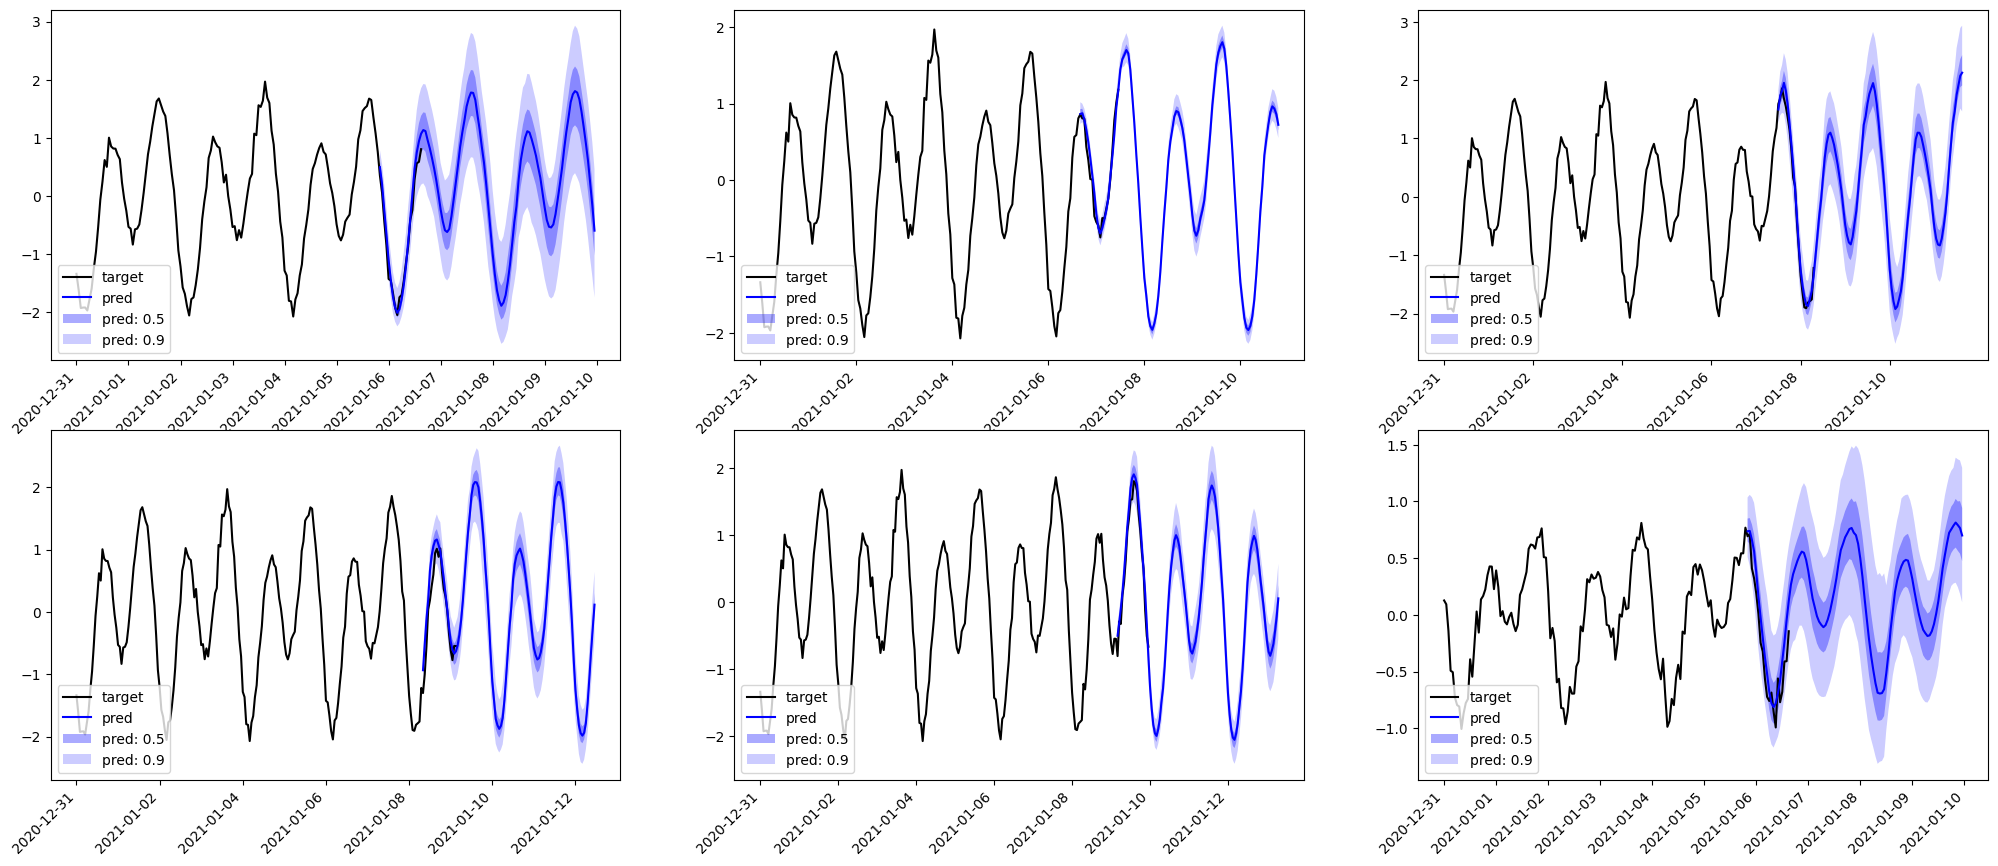

In [11]:
# Make predictions
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))
plot_next_multi(
    axes,
    input_it,
    label_it,
    forecast_it,
    context_length=200,
    intervals=(0.5, 0.9),
    dim=None,
    name="pred",
    show_label=True,
)

## 2.2 Loading from a _wide_ DataFrame

## 2.2 从宽DataFrame加载

In [12]:
# Load dataframe
url_wide = (
    "https://gist.githubusercontent.com/rsnirwan/c8c8654a98350fadd229b00167174ec4"
    "/raw/a42101c7786d4bc7695228a0f2c8cea41340e18f/ts_wide.csv"
)
df = pd.read_csv(url_wide, index_col=0, parse_dates=True)

df.head()

,A,B,C,D,E,F,G,H,I,J
2021-01-01 00:00:00,-1.3378,0.1268,-0.3645,-1.0864,-2.3803,-0.2447,2.2647,-0.7917,0.7071,1.3763
2021-01-01 01:00:00,-1.6111,0.0926,-0.1364,-1.1613,-2.1421,-0.3477,2.4262,-0.9609,0.6413,1.2750
2021-01-01 02:00:00,-1.9259,-0.1420,0.1063,-1.0405,-2.1426,-0.3271,2.4434,-0.9034,0.4323,0.6767
2021-01-01 03:00:00,-1.9184,-0.4930,0.6269,-0.8531,-1.7060,-0.3088,2.4307,-0.9602,0.3193,0.5150
2021-01-01 04:00:00,-1.9168,-0.5057,0.9419,-0.7666,-1.4287,-0.4284,2.3258,-1.2504,0.3660,0.1708


In [13]:
# 转换为GluonTS数据集
# 对于宽格式数据，每列是一个独立的时间序列
# 基于第一个可用列指定目标列
ds = PandasDataset(dict(df))

# Split into train/test set
# 分割为训练/测试集
train, test_template = split(
    ds, offset=-TEST
)  # assign last TEST time steps as test set # 将最后TEST个时间步分配为测试集

# Construct rolling window evaluation
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction # 每次预测的时间步数
    windows=TEST // PDT,  # number of windows in rolling window evaluation # 滚动窗口评估中的窗口数
    distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows # 每个窗口之间的时间步数 - distance=PDT表示非重叠窗口
)

In [14]:
# Prepare model
if MODEL == "moirai":
    model = MoiraiForecast(
        module=MoiraiModule.from_pretrained(f"/root/autodl-tmp/TSFMs/pretrained/Salesforce/moirai-1.1-R-small"),
        prediction_length=PDT,
        context_length=CTX,
        patch_size=PSZ,
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=ds.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    )
elif MODEL == "moirai-moe":
    model = MoiraiMoEForecast(
        module=MoiraiMoEModule.from_pretrained(f"/root/autodl-tmp/TSFMs/pretrained/Salesforce/moirai-moe-1.0-R-small"),
        prediction_length=PDT,
        context_length=CTX,
        patch_size=16,
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=ds.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    )
elif MODEL == "moirai2":
    model = Moirai2Forecast(
        module=Moirai2Module.from_pretrained(
            f"/root/autodl-tmp/TSFMs/pretrained/Salesforce/moirai-2.0-R-small",
        ),
        prediction_length=100,
        context_length=1680,
        target_dim=1,
        feat_dynamic_real_dim=0,
        past_feat_dynamic_real_dim=0,
    )

predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

Loading weights from local directory


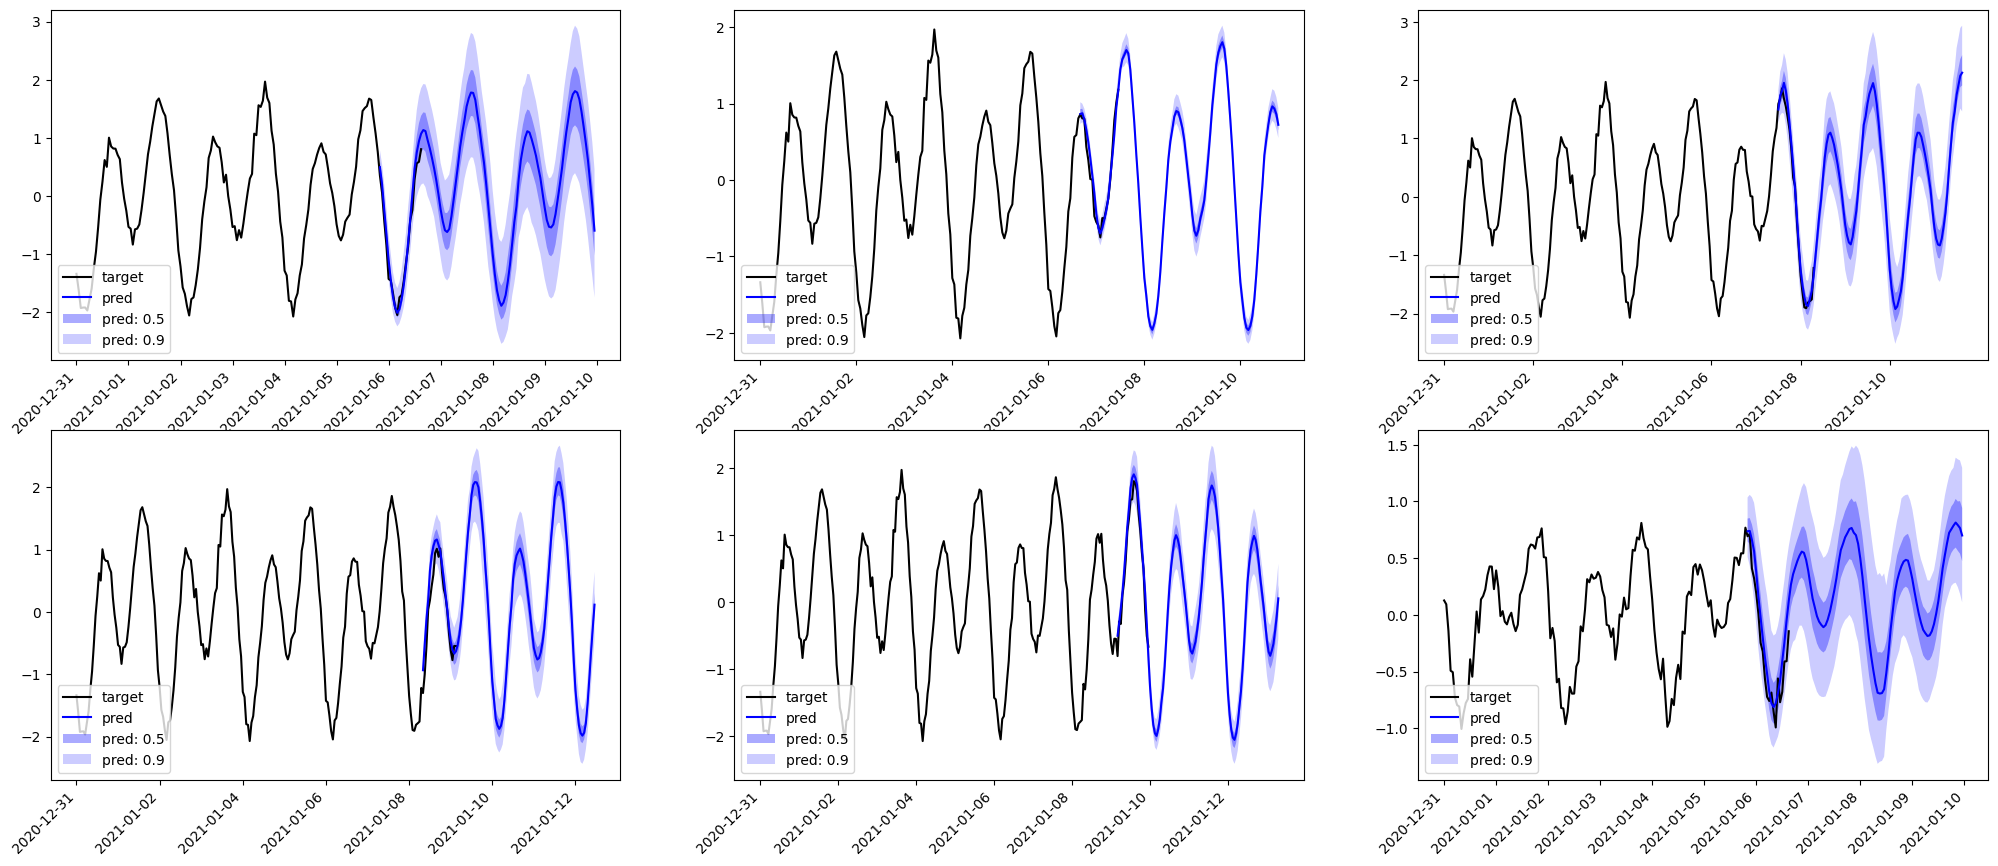

In [15]:
# Make predictions
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))
plot_next_multi(
    axes,
    input_it,
    label_it,
    forecast_it,
    context_length=200,
    intervals=(0.5, 0.9),
    dim=None,
    name="pred",
    show_label=True,
)

# 2.3 Multivariate Forecasting

# 2.3 多变量预测

In [16]:
# Load dataframe
url_wide = (
    "https://gist.githubusercontent.com/rsnirwan/c8c8654a98350fadd229b00167174ec4"
    "/raw/a42101c7786d4bc7695228a0f2c8cea41340e18f/ts_wide.csv"
)
df = pd.read_csv(url_wide, index_col=0, parse_dates=True)

In [17]:
# Convert into GluonTS dataset
# 转换为GluonTS数据集
ds = PandasDataset(dict(df))

# Group time series into multivariate dataset
# 将时间序列分组为多变量数据集
grouper = MultivariateGrouper(len(ds))
multivar_ds = grouper(ds)

# Split into train/test set
# 分割为训练/测试集
train, test_template = split(
    multivar_ds, offset=-TEST
)  # assign last TEST time steps as test set # 将最后TEST个时间步分配为测试集

# Construct rolling window evaluation
# 构建滚动窗口评估
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction # 每次预测的时间步数
    windows=TEST // PDT,  # number of windows in rolling window evaluation # 滚动窗口评估中的窗口数
    distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows # 每个窗口之间的时间步数 - distance=PDT表示非重叠窗口
)

In [18]:
# Prepare model
if MODEL == "moirai":
    model = MoiraiForecast(
        module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-small"),
        prediction_length=PDT,
        context_length=CTX,
        patch_size=PSZ,
        num_samples=100,
        target_dim=len(ds),
        feat_dynamic_real_dim=ds.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    )
elif MODEL == "moirai-moe":
    model = MoiraiMoEForecast(
        module=MoiraiMoEModule.from_pretrained(f"Salesforce/moirai-moe-1.0-R-small"),
        prediction_length=PDT,
        context_length=CTX,
        patch_size=16,
        num_samples=100,
        target_dim=len(ds),
        feat_dynamic_real_dim=ds.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    )
elif MODEL == "moirai2":
    model = Moirai2Forecast(
        module=Moirai2Module.from_pretrained(
            f"/root/autodl-tmp/TSFMs/pretrained/Salesforce/moirai-2.0-R-small",
        ),
        prediction_length=PDT,
        context_length=CTX,
        target_dim=len(ds),  # 多变量预测需要设置为数据集长度
        feat_dynamic_real_dim=ds.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    )

predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

Loading weights from local directory


In [19]:
# Make predictions
inp = next(input_it)
label = next(label_it)
forecast = next(forecast_it)

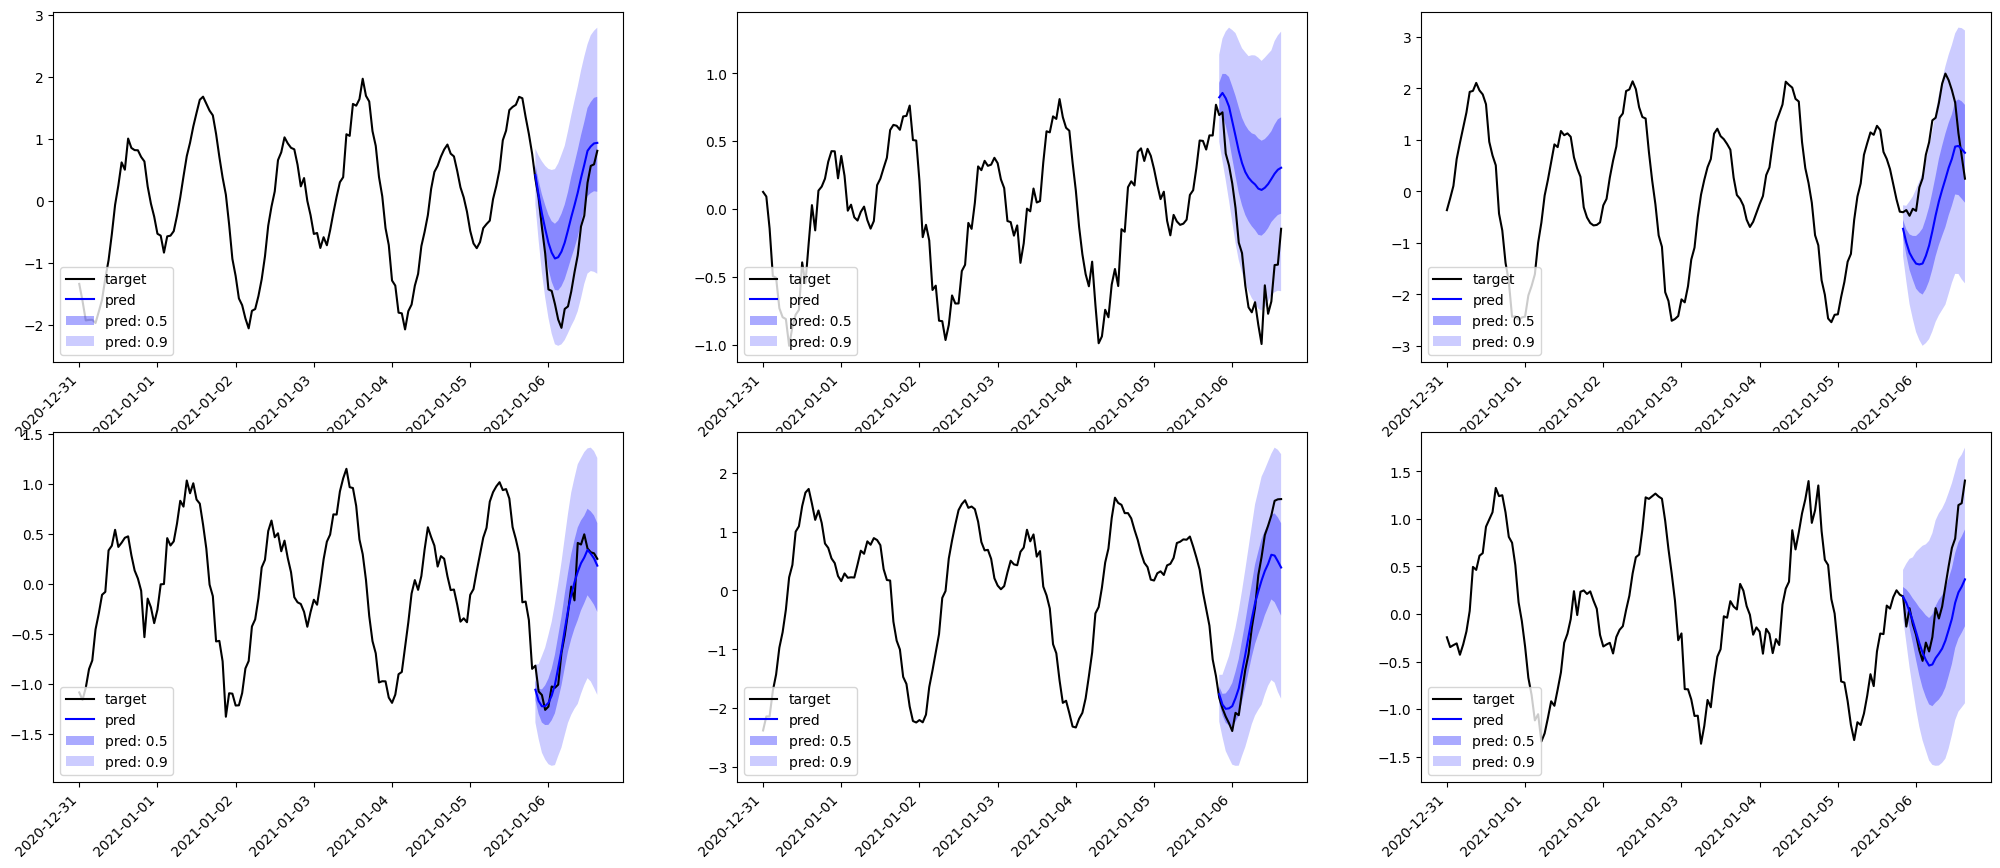

In [20]:
# Visualize different dimensions
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))
for i, ax in enumerate(axes.flatten()):
    plot_single(
        inp,
        label,
        forecast,
        context_length=200,
        intervals=(0.5, 0.9),
        dim=i,
        ax=ax,
        name="pred",
        show_label=True,
    )

## 2.4 Include dynamic features

## 2.4 包含动态特征

<img src="img/extra_feature.png" alt="Drawing" style="width: 800px;"/>

Moirai supports adding additional covariates. Specifically, it could include past dynamic real features, and dynamic real feature that include features in the prediction window.

Moirai支持添加额外的协变量。具体来说，它可以包括过去的动态实值特征，以及预测窗口中的动态实值特征。

In [21]:
# Load dataframe
url = (
    "https://gist.githubusercontent.com/rsnirwan/a8b424085c9f44ef2598da74ce43e7a3"
    "/raw/b6fdef21fe1f654787fa0493846c546b7f9c4df2/ts_long.csv"
)
df = pd.read_csv(url, index_col=0, parse_dates=True)
T = df.shape[0]
df["dynamic_real_1"] = np.random.normal(size=T)
df["past_dynamic_real_2"] = np.random.normal(size=T)

In [22]:
ds = PandasDataset.from_long_dataframe(
    df,
    item_id="item_id",
    past_feat_dynamic_real=["past_dynamic_real_2"],
    feat_dynamic_real=["dynamic_real_1"],
)

# Split into train/test set
# 分割为训练/测试集
train, test_template = split(
    ds, offset=-TEST
)  # assign last TEST time steps as test set # 将最后TEST个时间步分配为测试集

# Construct rolling window evaluation
# 构建滚动窗口评估
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction # 每次预测的时间步数
    windows=TEST // PDT,  # number of windows in rolling window evaluation # 滚动窗口评估中的窗口数
    distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows # 每个窗口之间的时间步数 - distance=PDT表示非重叠窗口
)

In [23]:
# Prepare model
if MODEL == "moirai":
    model = MoiraiForecast(
        module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-small"),
        prediction_length=PDT,
        context_length=CTX,
        patch_size=PSZ,
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=ds.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    )
elif MODEL == "moirai-moe":
    model = MoiraiMoEForecast(
        module=MoiraiMoEModule.from_pretrained(f"Salesforce/moirai-moe-1.0-R-small"),
        prediction_length=PDT,
        context_length=CTX,
        patch_size=16,
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=ds.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    )
elif MODEL == "moirai2":
    model = Moirai2Forecast(
        module=Moirai2Module.from_pretrained(
            f"/root/autodl-tmp/TSFMs/pretrained/Salesforce/moirai-2.0-R-small",
        ),
        prediction_length=PDT,
        context_length=CTX,
        target_dim=1,
        feat_dynamic_real_dim=ds.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    )

predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

Loading weights from local directory


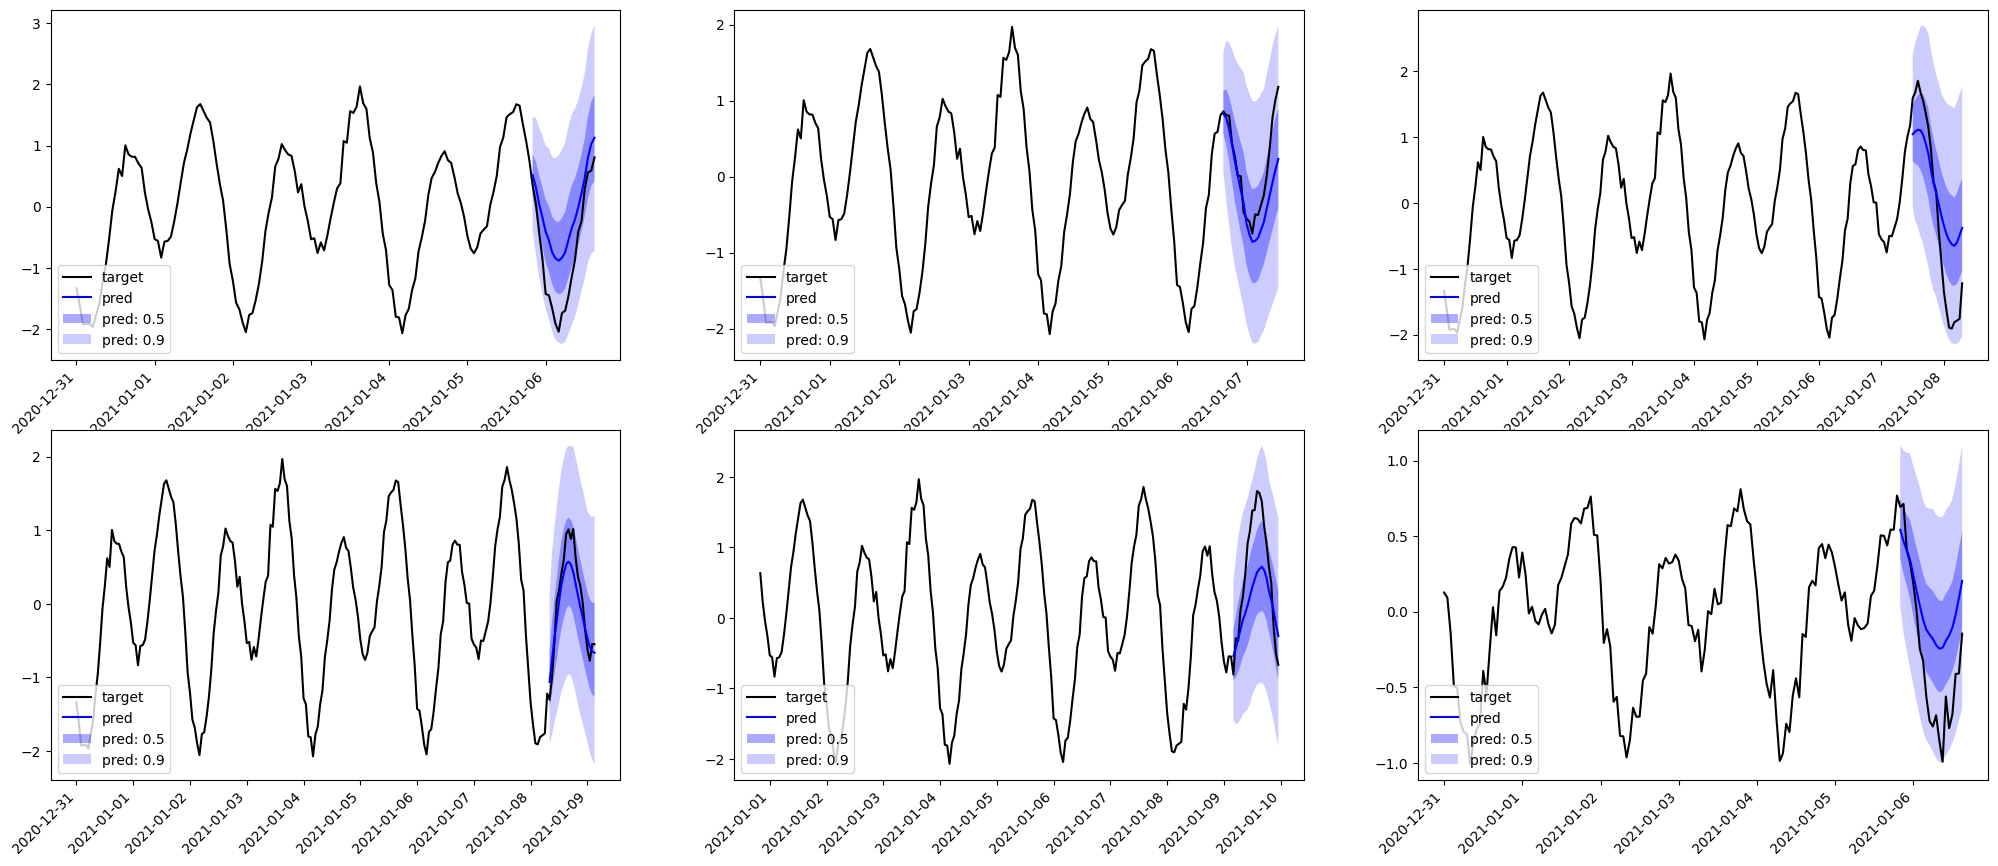

In [24]:
# Make predictions
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))
plot_next_multi(
    axes,
    input_it,
    label_it,
    forecast_it,
    context_length=200,
    intervals=(0.5, 0.9),
    dim=None,
    name="pred",
    show_label=True,
)